In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

import sklearn
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import logomaker as lm
from tqdm import tqdm
from collections import defaultdict
import pickle as pkl
import os
import sys

In [3]:
threshold = 1000

wt = pd.read_csv("2-EGFR-R4.txt", sep='\t', header = 0)
wt = wt.sort_values("Counts", ascending = False)
wt = wt.drop(['Name'],axis=1)
wt = wt[wt.Counts >= threshold]

In [4]:
wt

,Counts,Sequences
0,256573,ACGDRQQACEARGNQCG
1,169154,ACISSEPSCQLKLRDCG
2,110682,ACEALSRACKSQVRNCG
3,105419,ACPAHSMSCQLEWRLCG
4,84017,ACKWGSSMCQVHSVWCG
...,...,...
1140,1003,ACVIDAGQCLGVLAGCG
1139,1003,ACQASRSACVKVQMCCG
1141,1001,ACSGTQQSCDDAARDCG
1142,1001,ACRQATLCCGVRAAACG


In [5]:
def check_abnormal_aa(peptide_seq):
    len_seq = len(peptide_seq)
    cnt = 0
    standard_aa = ['G','A','P','V','L','I','M','F','Y','W','S','T','C','N','Q','K','H','R','D','E']
    f=1
    for i in peptide_seq:
        if i not in standard_aa :
            f=0
    return f

In [6]:
wt["all_standard"] = wt.Sequences.apply(check_abnormal_aa)
wt = wt[wt.all_standard==1]
wt.shape[0]

1144

In [7]:
wt["log_counts"]=np.log10(wt.Counts)
wt = wt.drop(['all_standard'],axis=1)

In [8]:
wt

,Counts,Sequences,log_counts
0,256573,ACGDRQQACEARGNQCG,5.409211
1,169154,ACISSEPSCQLKLRDCG,5.228282
2,110682,ACEALSRACKSQVRNCG,5.044077
3,105419,ACPAHSMSCQLEWRLCG,5.022919
4,84017,ACKWGSSMCQVHSVWCG,4.924367
...,...,...,...
1140,1003,ACVIDAGQCLGVLAGCG,3.001301
1139,1003,ACQASRSACVKVQMCCG,3.001301
1141,1001,ACSGTQQSCDDAARDCG,3.000434
1142,1001,ACRQATLCCGVRAAACG,3.000434


In [9]:
wt_esm = np.load('EGFRwtR4_esm2_t33_650M_UR50D.npy')

In [10]:
DIMRED = TSNE
s = DIMRED(n_components=2, random_state=3).fit_transform(wt_esm)

/Users/minghanwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/minghanwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='TSNE1', ylabel='TSNE2'>

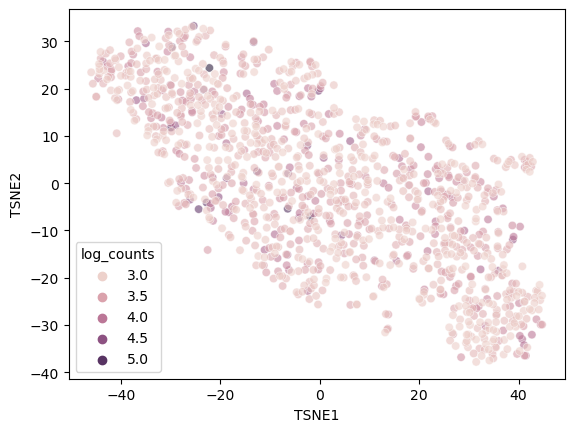

In [11]:
wt["TSNE1"]=s[:,0]
wt["TSNE2"]=s[:,1]
sns.scatterplot(x="TSNE1", y="TSNE2", hue="log_counts",data=wt,alpha=0.6)

In [12]:
kmeans = KMeans(init="random",n_clusters=10,max_iter=300,random_state=42)

In [13]:
kmeans.fit(wt_esm)

KMeans(init='random', n_clusters=10, random_state=42)

In [14]:
wt["cluster"] = kmeans.labels_

In [15]:
wt["cluster"] = wt.cluster.astype(str)

In [16]:
wt

,Counts,Sequences,log_counts,TSNE1,TSNE2,cluster
0,256573,ACGDRQQACEARGNQCG,5.409211,-22.188330,24.387434,9
1,169154,ACISSEPSCQLKLRDCG,5.228282,-1.901084,-7.028013,7
2,110682,ACEALSRACKSQVRNCG,5.044077,-6.438897,-5.401693,7
3,105419,ACPAHSMSCQLEWRLCG,5.022919,-29.919920,11.792632,5
4,84017,ACKWGSSMCQVHSVWCG,4.924367,-22.757156,-4.103047,7
...,...,...,...,...,...,...
1140,1003,ACVIDAGQCLGVLAGCG,3.001301,44.208984,-21.508951,0
1139,1003,ACQASRSACVKVQMCCG,3.001301,-6.727105,2.068843,7
1141,1001,ACSGTQQSCDDAARDCG,3.000434,-0.289665,10.397219,7
1142,1001,ACRQATLCCGVRAAACG,3.000434,-29.033112,27.023348,9


In [17]:
stat = wt.groupby("cluster").agg({"Counts": ["size", "median","mean", "max", "min"]})
stat = stat.sort_values(by = ("Counts", "median"), ascending = False)
stat

Counts                                   
          size  median         mean     max   min
cluster                                          
6          115  1748.0  3985.643478   60615  1008
2          161  1735.0  2998.248447   21448  1005
0          105  1687.0  2797.238095   21506  1003
7          183  1663.0  5638.939891  169154  1001
4           83  1620.0  2710.578313   23365  1006
3          101  1619.0  2640.762376   12875  1011
9          143  1619.0  5520.048951  256573  1001
5          131  1577.0  3525.687023  105419  1008
1           22  1438.5  1945.318182    4633  1011
8          100  1365.0  2417.060000   14169  1000

<AxesSubplot:xlabel='TSNE1', ylabel='TSNE2'>

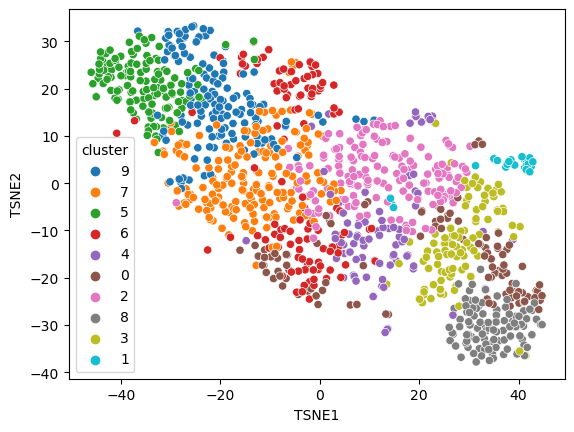

In [18]:
wt["TSNE1"]=s[:,0]
wt["TSNE2"]=s[:,1]
sns.scatterplot(x="TSNE1", y="TSNE2", hue="cluster",data=wt)

In [19]:
def seqlogo_cluster(df,cluster,weighted=False,displot=True):
    c_df=df[df.cluster==cluster]
    # print(f"Cluster: {cluster}, num: {c_df.shape[0]} ")
    if weighted:
        weighted_peptide=[]
        for index,row in c_df.iterrows():
            weighted_peptide.extend([row["Sequences1"]]*row["Counts"])
        matrix=lm.alignment_to_matrix(weighted_peptide,to_type='information')
    else:
        matrix=lm.alignment_to_matrix(c_df.Sequences1,to_type='information')
        
        
    info_logo=lm.Logo(matrix,color_scheme="chemistry")
    info_logo.ax.set_ylabel('information (bits)')
    plt.title(f'Cluster: {cluster}, Size: {c_df.shape[0]},Median counts: {np.median(c_df.Counts)}, Mean counts: {np.mean(c_df.Counts)}, Max count: {np.max(c_df.Counts)}, Min count:{np.min(c_df.Counts)}')

    if displot:
        sns.displot(c_df.log_counts)

In [20]:
wt["Sequences1"]=wt.Sequences.apply(lambda x: x[2:8]+x[9:15])
wt

,Counts,Sequences,log_counts,TSNE1,TSNE2,cluster,Sequences1
0,256573,ACGDRQQACEARGNQCG,5.409211,-22.188330,24.387434,9,GDRQQAEARGNQ
1,169154,ACISSEPSCQLKLRDCG,5.228282,-1.901084,-7.028013,7,ISSEPSQLKLRD
2,110682,ACEALSRACKSQVRNCG,5.044077,-6.438897,-5.401693,7,EALSRAKSQVRN
3,105419,ACPAHSMSCQLEWRLCG,5.022919,-29.919920,11.792632,5,PAHSMSQLEWRL
4,84017,ACKWGSSMCQVHSVWCG,4.924367,-22.757156,-4.103047,7,KWGSSMQVHSVW
...,...,...,...,...,...,...,...
1140,1003,ACVIDAGQCLGVLAGCG,3.001301,44.208984,-21.508951,0,VIDAGQLGVLAG
1139,1003,ACQASRSACVKVQMCCG,3.001301,-6.727105,2.068843,7,QASRSAVKVQMC
1141,1001,ACSGTQQSCDDAARDCG,3.000434,-0.289665,10.397219,7,SGTQQSDDAARD
1142,1001,ACRQATLCCGVRAAACG,3.000434,-29.033112,27.023348,9,RQATLCGVRAAA


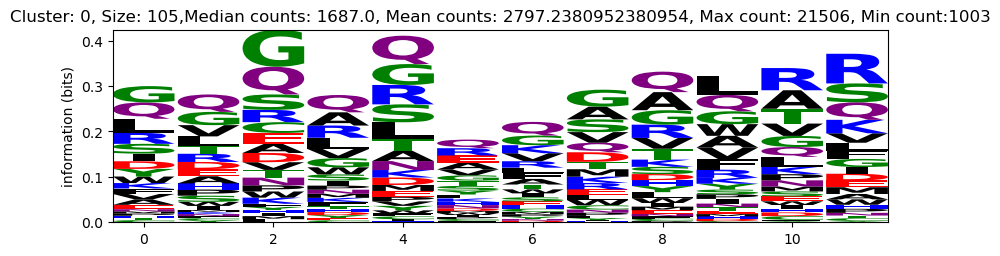

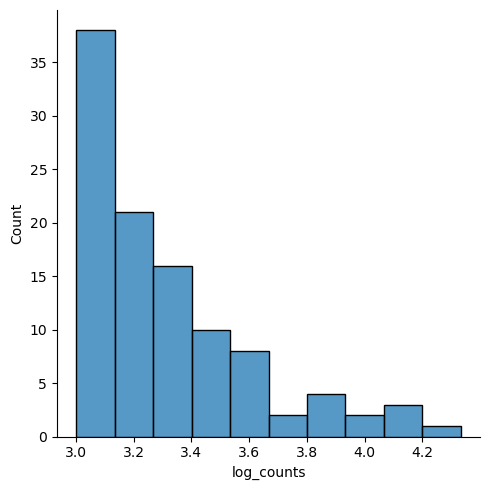

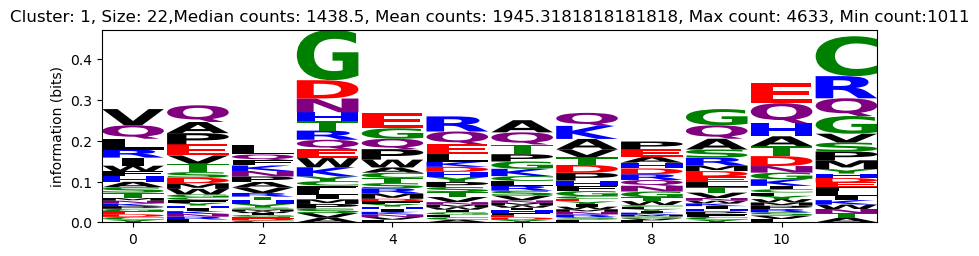

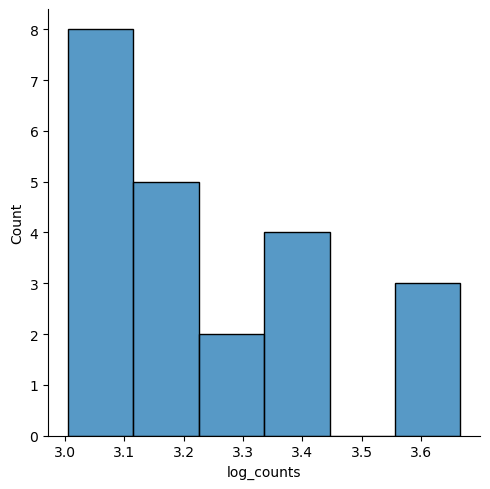

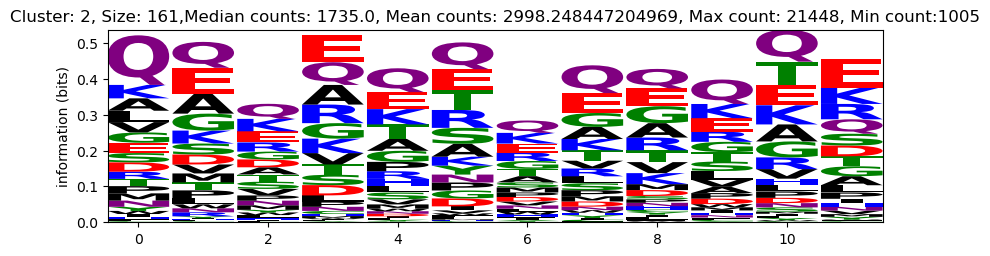

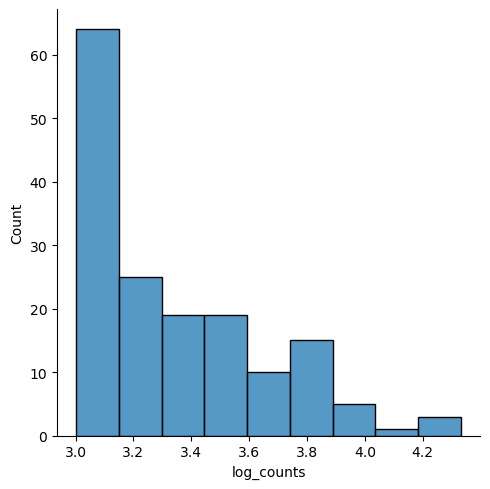

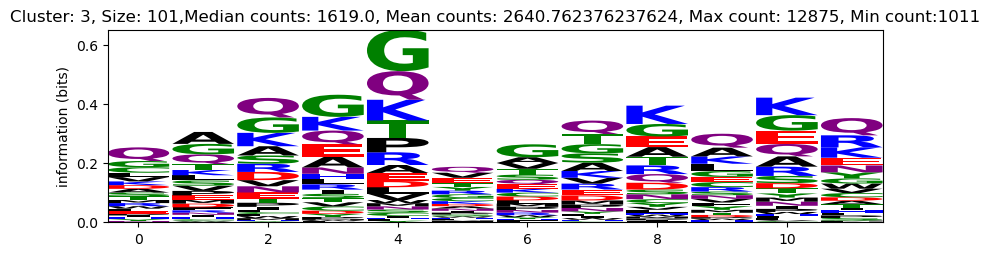

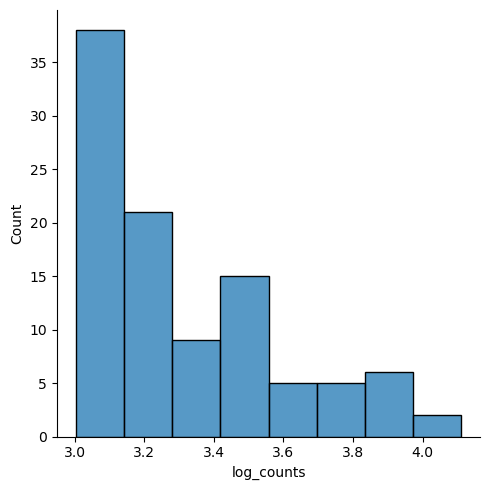

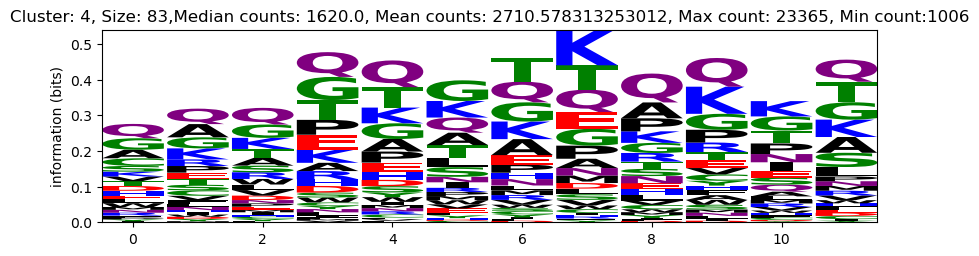

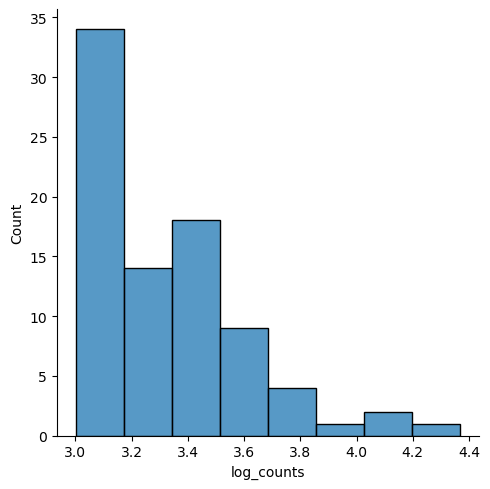

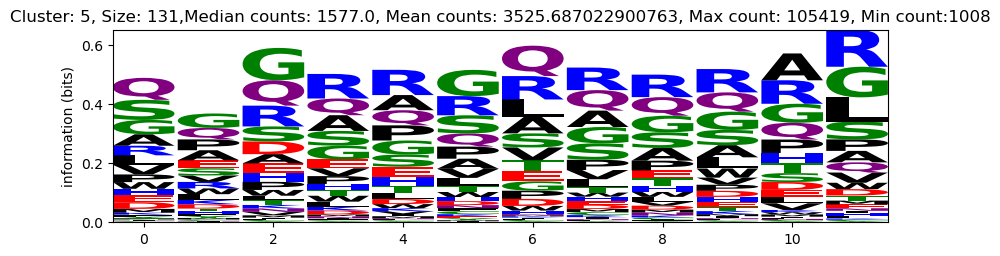

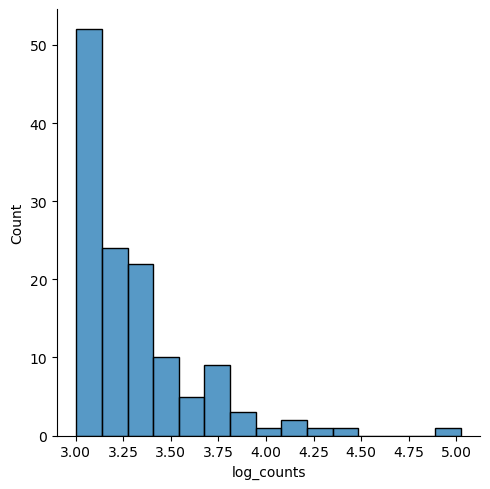

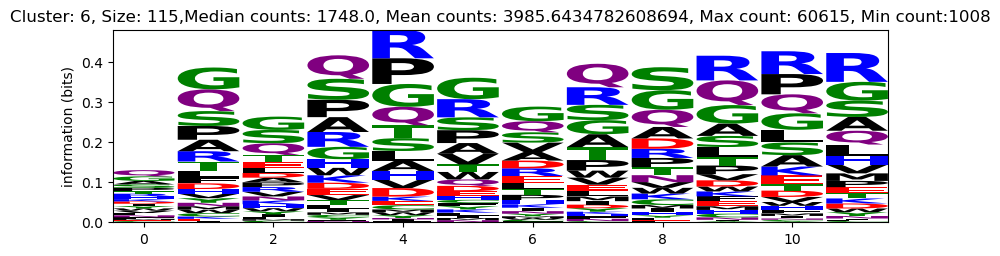

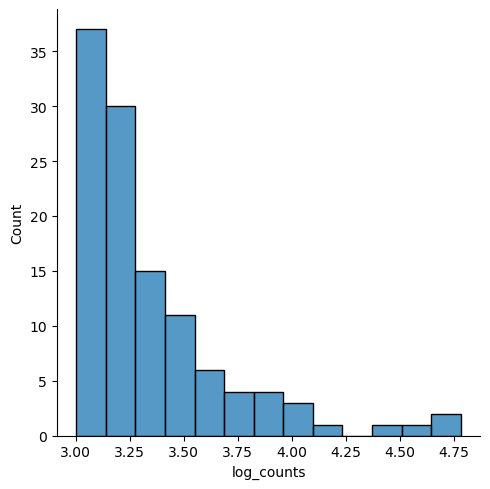

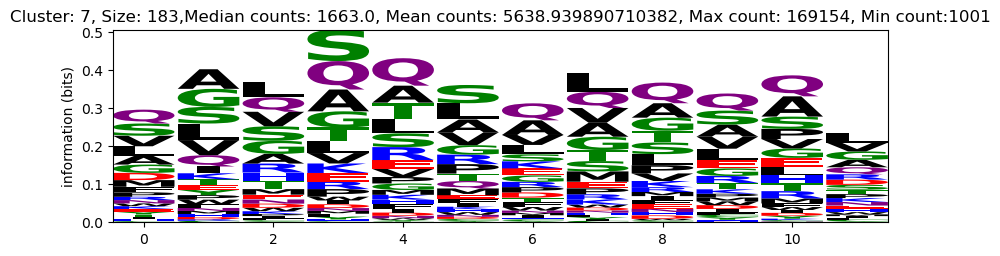

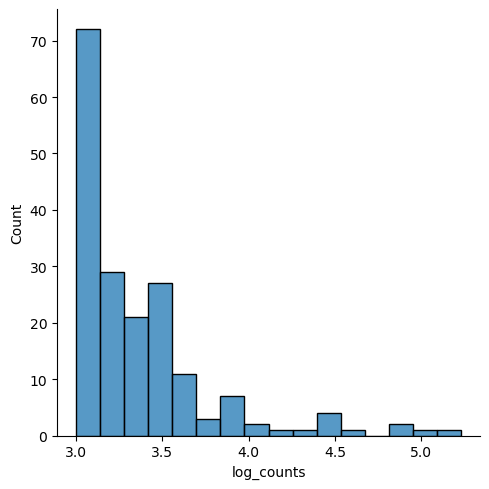

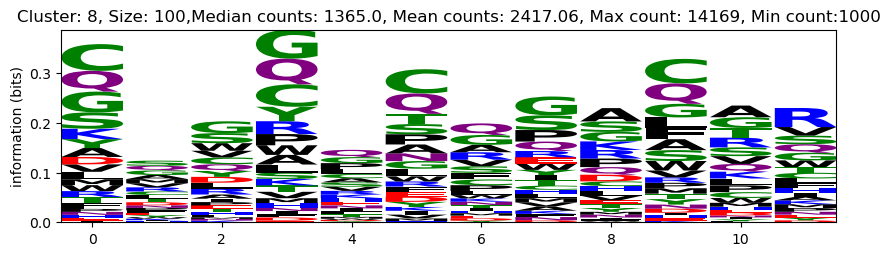

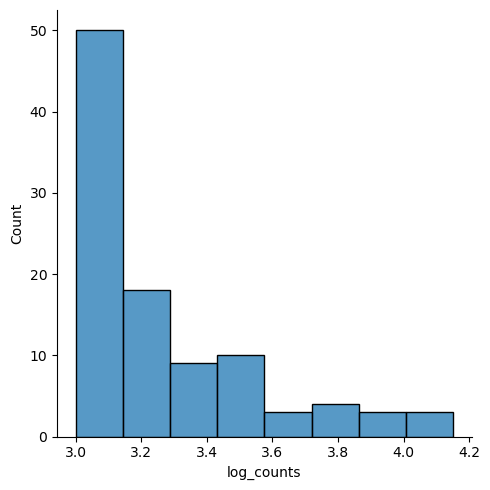

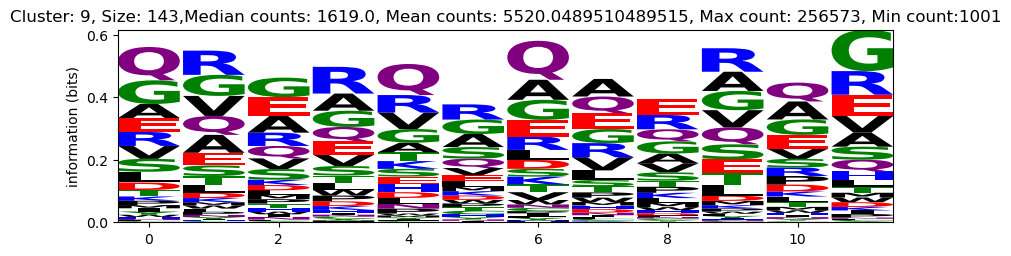

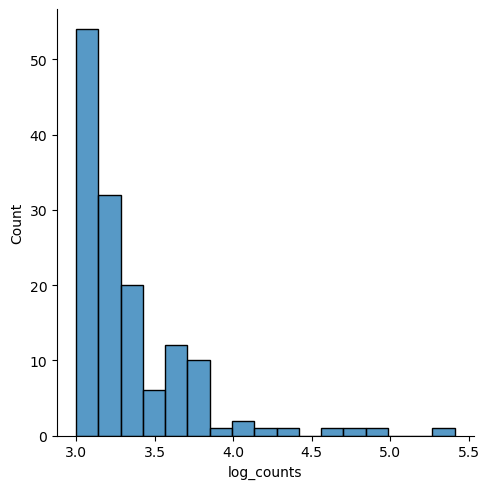

In [21]:
for i in range(10):
    seqlogo_cluster(wt,str(i))

In [63]:
stat.to_csv("EGFRwtR4_esm_cluster_statistics.csv")
wt.loc[:, ["Sequences", "Counts", "cluster"]].to_csv('EGFRwtR4_esm_cluster.csv')